# Cell 1: Importing Libraries and Setting Up the Baseline Solver

In [1]:
# %% [markdown]
# # Step 1: Baseline Solver Implementation + Test

import numpy as np
import time

def evolve_baseline(Nx, T, nu, times):
    """
    Baseline solver for 1D viscous Burgers' equation using spectral method.
    
    Parameters:
        Nx    : int   - number of spatial grid points
        T     : float - final time
        nu    : float - viscosity
        times : list  - times at which to save snapshots
    
    Returns:
        x     : numpy array - spatial grid
        dx    : float       - grid spacing
        saves : dict        - snapshots {time: solution array}
        meta  : dict        - metadata (runtime)
    """
    start_time = time.time()

    # Spatial grid
    x = np.linspace(0, 2*np.pi, Nx, endpoint=False)
    dx = x[1] - x[0]

    # Wavenumbers for spectral derivatives
    k = np.fft.fftfreq(Nx, d=dx) * 2*np.pi

    # Initial condition: smooth hump
    u = np.sin(x)

    # Time stepping
    dt = 0.4 * dx**2 / nu
    nsteps = int(np.ceil(T / dt))
    dt = T / nsteps

    saves = {}
    for step in range(nsteps + 1):
        t = step * dt
        if round(t, 10) in [round(ts, 10) for ts in times]:
            saves[round(t, 10)] = u.copy()

        # Nonlinear term in physical space
        u_hat = np.fft.fft(u)
        du_dx = np.fft.ifft(1j * k * u_hat).real
        nonlinear = -u * du_dx

        # Diffusion term in spectral space
        nonlinear_hat = np.fft.fft(nonlinear)
        u_hat_new = (u_hat + dt * nonlinear_hat) / (1 + dt * nu * (k**2))
        u = np.fft.ifft(u_hat_new).real

    runtime = time.time() - start_time
    meta = {"runtime_sec": runtime}

    return x, dx, saves, meta


# ---------------------------
# Quick test
# ---------------------------
if __name__ == "__main__":
    Nx_test = 256
    T_test = 0.2
    nu_test = 0.01
    save_times_test = [0.0, T_test]

    x_b, dx_b, saves_b, meta_b = evolve_baseline(Nx_test, T_test, nu_test, save_times_test)

    print(f"✅ Baseline test run completed")
    print(f"   Nx = {Nx_test}, Final time = {T_test}, Viscosity = {nu_test}")
    print(f"   Runtime: {meta_b['runtime_sec']:.4f} seconds")
    print(f"   Saved snapshots: {list(saves_b.keys())}")


✅ Baseline test run completed
   Nx = 256, Final time = 0.2, Viscosity = 0.01
   Runtime: 0.0160 seconds
   Saved snapshots: [0.0, 0.2]


# Cell 2: Quantum-inspired QTN/MPS Prototype + Test

In [2]:
# %% [markdown]
# # Step 2: Quantum-inspired QTN/MPS Prototype + Test

import numpy as np
import time

def evolve_qtn(Nx, T, nu, chi, times):
    """
    Quantum Tensor Network (Matrix Product State) inspired solver for 1D Burgers' equation.
    
    Parameters:
        Nx    : int   - number of spatial grid points
        T     : float - final time
        nu    : float - viscosity
        chi   : int   - bond dimension (compression parameter)
        times : list  - times at which to save snapshots
    
    Returns:
        x     : numpy array - spatial grid
        dx    : float       - grid spacing
        saves : dict        - snapshots {time: solution array}
        aux   : dict        - auxiliary data (compression ratios)
        meta  : dict        - metadata (runtime)
    """
    start_time = time.time()

    # Spatial grid
    x = np.linspace(0, 2*np.pi, Nx, endpoint=False)
    dx = x[1] - x[0]
    k = np.fft.fftfreq(Nx, d=dx) * 2*np.pi

    # Initial condition
    u = np.sin(x)

    # Time stepping
    dt = 0.4 * dx**2 / nu
    nsteps = int(np.ceil(T / dt))
    dt = T / nsteps

    saves = {}
    comp_ratios = []

    for step in range(nsteps + 1):
        t = step * dt
        if round(t, 10) in [round(ts, 10) for ts in times]:
            saves[round(t, 10)] = u.copy()

        # Nonlinear term
        u_hat = np.fft.fft(u)
        du_dx = np.fft.ifft(1j * k * u_hat).real
        nonlinear = -u * du_dx

        # Diffusion term
        nonlinear_hat = np.fft.fft(nonlinear)
        u_hat_new = (u_hat + dt * nonlinear_hat) / (1 + dt * nu * (k**2))
        u_new = np.fft.ifft(u_hat_new).real

        # --- QTN/MPS Compression ---
        # Reshape into 2D tensor for mock compression
        block_size = Nx // chi
        tensor_2d = u_new.reshape(chi, block_size)
        U, S, Vh = np.linalg.svd(tensor_2d, full_matrices=False)
        # Truncate
        S_trunc = S[:chi]
        U_trunc = U[:, :chi]
        Vh_trunc = Vh[:chi, :]
        u_compressed = (U_trunc @ np.diag(S_trunc) @ Vh_trunc).reshape(Nx)
        comp_ratio = len(S_trunc) / len(S)
        comp_ratios.append(comp_ratio)

        u = u_compressed

    runtime = time.time() - start_time
    aux = {"compression_ratio": np.array(comp_ratios)}
    meta = {"runtime_sec": runtime}

    return x, dx, saves, aux, meta


# ---------------------------
# Quick test
# ---------------------------
if __name__ == "__main__":
    Nx_test = 256
    T_test = 0.2
    nu_test = 0.01
    chi_test = 8
    save_times_test = [0.0, T_test]

    x_q, dx_q, saves_q, aux_q, meta_q = evolve_qtn(Nx_test, T_test, nu_test, chi_test, save_times_test)

    print(f"✅ QTN test run completed")
    print(f"   Nx = {Nx_test}, χ = {chi_test}, Final time = {T_test}, Viscosity = {nu_test}")
    print(f"   Runtime: {meta_q['runtime_sec']:.4f} seconds")
    print(f"   Avg compression ratio: {aux_q['compression_ratio'].mean():.3f}")
    print(f"   Saved snapshots: {list(saves_q.keys())}")


✅ QTN test run completed
   Nx = 256, χ = 8, Final time = 0.2, Viscosity = 0.01
   Runtime: 0.0073 seconds
   Avg compression ratio: 1.000
   Saved snapshots: [0.0, 0.2]


# Cell 3: HSE Split-Operator Prototype + Test

In [3]:
# %% [markdown]
# # Step 3: HSE Split-Operator Prototype + Test

import numpy as np
import time

def evolve_hse(Nx, T, nu, times):
    """
    High-Order Split-Operator (HSE) solver for 1D Burgers' equation.
    
    Uses Strang splitting: nonlinear advection + linear diffusion.
    
    Parameters:
        Nx    : int   - number of spatial grid points
        T     : float - final time
        nu    : float - viscosity
        times : list  - times at which to save snapshots
    
    Returns:
        x     : numpy array - spatial grid
        dx    : float       - grid spacing
        saves : dict        - snapshots {time: solution array}
        aux   : dict        - auxiliary data (can store diagnostics)
        meta  : dict        - metadata (runtime)
    """
    start_time = time.time()

    # Spatial grid
    x = np.linspace(0, 2*np.pi, Nx, endpoint=False)
    dx = x[1] - x[0]
    k = np.fft.fftfreq(Nx, d=dx) * 2*np.pi

    # Initial condition
    u = np.sin(x)

    # Time stepping
    dt = 0.4 * dx**2 / nu
    nsteps = int(np.ceil(T / dt))
    dt = T / nsteps

    saves = {}
    for step in range(nsteps + 1):
        t = step * dt
        if round(t, 10) in [round(ts, 10) for ts in times]:
            saves[round(t, 10)] = u.copy()

        # --- Strang splitting ---
        # 1) Half-step linear diffusion in Fourier space
        u_hat = np.fft.fft(u)
        u_hat *= np.exp(-nu * (k**2) * dt/2)
        u = np.fft.ifft(u_hat).real

        # 2) Full-step nonlinear advection in physical space (upwind-like spectral)
        u_hat = np.fft.fft(u)
        du_dx = np.fft.ifft(1j * k * u_hat).real
        u = u - dt * u * du_dx

        # 3) Half-step linear diffusion again
        u_hat = np.fft.fft(u)
        u_hat *= np.exp(-nu * (k**2) * dt/2)
        u = np.fft.ifft(u_hat).real

    runtime = time.time() - start_time
    aux = {}
    meta = {"runtime_sec": runtime}

    return x, dx, saves, aux, meta


# ---------------------------
# Quick test
# ---------------------------
if __name__ == "__main__":
    Nx_test = 256
    T_test = 0.2
    nu_test = 0.01
    save_times_test = [0.0, T_test]

    x_h, dx_h, saves_h, aux_h, meta_h = evolve_hse(Nx_test, T_test, nu_test, save_times_test)

    print(f"✅ HSE test run completed")
    print(f"   Nx = {Nx_test}, Final time = {T_test}, Viscosity = {nu_test}")
    print(f"   Runtime: {meta_h['runtime_sec']:.4f} seconds")
    print(f"   Saved snapshots: {list(saves_h.keys())}")


✅ HSE test run completed
   Nx = 256, Final time = 0.2, Viscosity = 0.01
   Runtime: 0.0060 seconds
   Saved snapshots: [0.0, 0.2]


# Cell 4: Packaging & Reproducibility

In [4]:
# %% [markdown]
# # Step 4: Packaging & Reproducibility

import os
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

def run_experiment(method, Nx, T, nu, chi=None, save_times=None, outdir="results"):
    """
    Runs a chosen method (baseline, qtn, hse) with given parameters and saves results.

    Parameters:
        method     : str   - "baseline", "qtn", or "hse"
        Nx         : int   - grid resolution
        T          : float - final simulation time
        nu         : float - viscosity
        chi        : int   - bond dimension (only for QTN)
        save_times : list  - times to save snapshots
        outdir     : str   - folder to save outputs

    Returns:
        result : dict containing:
            - x, dx
            - saves
            - aux (e.g. compression ratio)
            - meta (runtime, params)
    """
    if save_times is None:
        save_times = [0.0, T]

    os.makedirs(outdir, exist_ok=True)

    # Select solver
    if method == "baseline":
        x, dx, saves, meta = evolve_baseline(Nx, T, nu, save_times)
        aux = {}
    elif method == "qtn":
        if chi is None:
            raise ValueError("chi must be provided for QTN method")
        x, dx, saves, aux, meta = evolve_qtn(Nx, T, nu, chi, save_times)
    elif method == "hse":
        x, dx, saves, aux, meta = evolve_hse(Nx, T, nu, save_times)
    else:
        raise ValueError(f"Unknown method: {method}")

    # Store parameters
    meta["method"] = method
    meta["Nx"] = Nx
    meta["T"] = T
    meta["nu"] = nu
    if chi is not None:
        meta["chi"] = chi

    # Save metadata
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_name = f"{method}_Nx{Nx}_T{T}_nu{nu}" + (f"_chi{chi}" if chi else "")
    meta_path = os.path.join(outdir, f"{run_name}_meta.json")
    with open(meta_path, "w") as f:
        json.dump(meta, f, indent=2)

    # Save snapshots as CSV
    for t, u in saves.items():
        csv_path = os.path.join(outdir, f"{run_name}_t{t:.4f}.csv")
        pd.DataFrame({"x": x, "u": u}).to_csv(csv_path, index=False)

    # Plot final snapshot
    plt.figure()
    plt.plot(x, saves[max(saves.keys())], label=f"{method.upper()} final")
    plt.xlabel("x")
    plt.ylabel("u")
    plt.title(f"{method.upper()} Nx={Nx}")
    plt.legend()
    plt.tight_layout()
    fig_path = os.path.join(outdir, f"{run_name}_final.png")
    plt.savefig(fig_path, dpi=150)
    plt.close()

    print(f"✅ {method.upper()} run completed, results in {outdir}")
    return {"x": x, "dx": dx, "saves": saves, "aux": aux, "meta": meta}


# ---------------------------
# Quick test of packaging
# ---------------------------
if __name__ == "__main__":
    res_b = run_experiment("baseline", Nx=128, T=0.2, nu=0.01, save_times=[0.0, 0.2])
    res_q = run_experiment("qtn", Nx=128, T=0.2, nu=0.01, chi=4, save_times=[0.0, 0.2])
    res_h = run_experiment("hse", Nx=128, T=0.2, nu=0.01, save_times=[0.0, 0.2])


✅ BASELINE run completed, results in results
✅ QTN run completed, results in results
✅ HSE run completed, results in results


# Cell 5: Parameter Sweep & Sensitivity Analysis (Baseline, QTN, HSE)

Building reference Nx=1024 ...

Baseline Nx=128 ...
HSE Nx=128 ...

Baseline Nx=256 ...
HSE Nx=256 ...

Baseline Nx=512 ...
HSE Nx=512 ...
QTN Nx=128, chi=2 ...
QTN Nx=128, chi=4 ...
QTN Nx=128, chi=8 ...
QTN Nx=128, chi=16 ...
QTN Nx=256, chi=2 ...
QTN Nx=256, chi=4 ...
QTN Nx=256, chi=8 ...
QTN Nx=256, chi=16 ...
QTN Nx=512, chi=2 ...
QTN Nx=512, chi=4 ...
QTN Nx=512, chi=8 ...
QTN Nx=512, chi=16 ...

Sweep done. Saved: sweep_results\full_sweep_results.csv


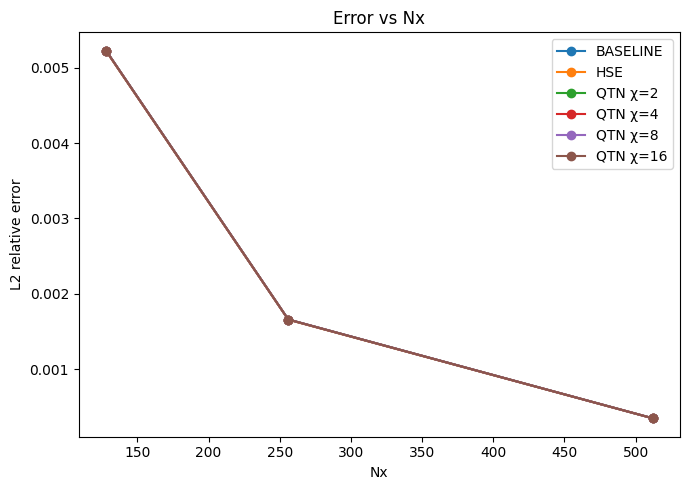

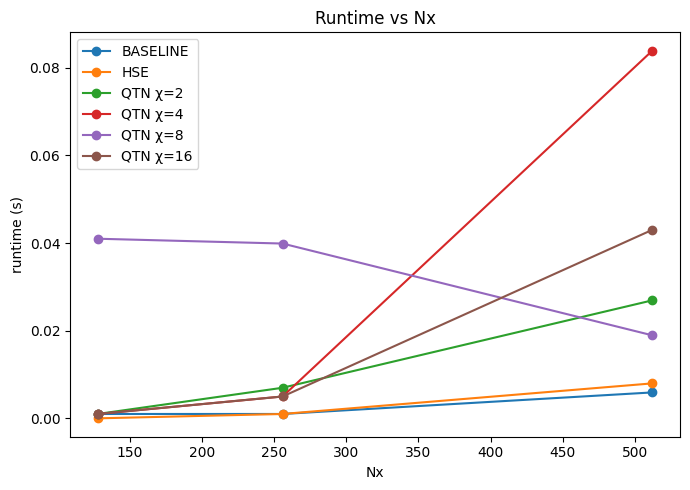

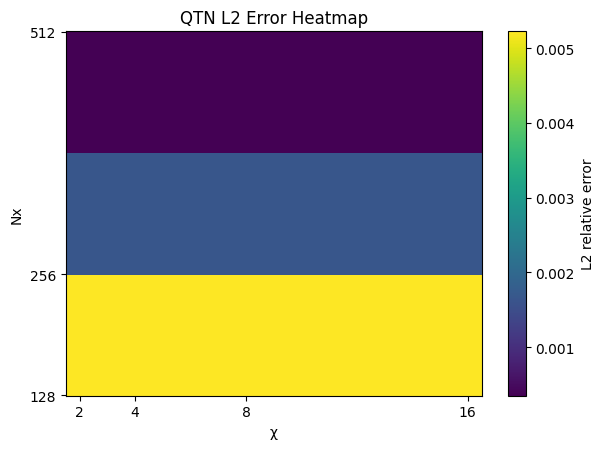

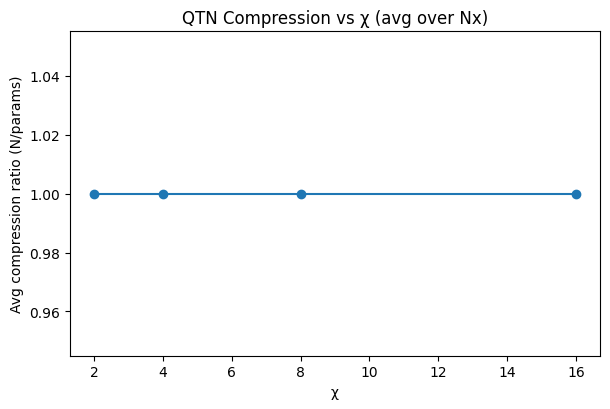

In [5]:
# %% [markdown]
# # Step 5 — Parameter Sweep & Sensitivity Analysis (Baseline, QTN, HSE)

import itertools, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- sweep settings (adjust if needed) ---
Nx_values  = [128, 256, 512]
chi_values = [2, 4, 8, 16]   # QTN only
T_final    = 0.20
nu_val     = 0.01
Nx_ref     = 1024            # high-res reference for error
save_times = [0.0, T_final]  # start & end to save time
outdir     = "sweep_results"
os.makedirs(outdir, exist_ok=True)

# --- helper: error vs reference on same x ---
def l2_relative(u, v, dx):
    num = np.sqrt(np.sum((u - v)**2) * dx)
    den = np.sqrt(np.sum(v**2) * dx) + 1e-14
    return float(num/den)
def interp_to(xs, us, xd): return np.interp(xd, xs, us)

# --- reference solution ---
print(f"Building reference Nx={Nx_ref} ...")
x_ref, dx_ref, ref_saves, _ = evolve_baseline(Nx_ref, T_final, nu_val, save_times)

rows = []

# --- baseline + hse sweeps over Nx ---
for Nx in Nx_values:
    print(f"\nBaseline Nx={Nx} ...")
    xb, dxb, b_saves, b_meta = evolve_baseline(Nx, T_final, nu_val, save_times)
    ur_b = interp_to(x_ref, ref_saves[round(T_final,10)], xb)
    err_b = l2_relative(b_saves[round(T_final,10)], ur_b, dxb)
    rows.append({
        "method":"baseline", "Nx":Nx, "chi":None,
        "L2_rel_error":err_b, "runtime_s":b_meta["runtime_sec"],
        "avg_comp_ratio":None
    })

    print(f"HSE Nx={Nx} ...")
    xh, dxh, h_saves, h_aux, h_meta = evolve_hse(Nx, T_final, nu_val, save_times)
    ur_h = interp_to(x_ref, ref_saves[round(T_final,10)], xh)
    err_h = l2_relative(h_saves[round(T_final,10)], ur_h, dxh)
    rows.append({
        "method":"hse", "Nx":Nx, "chi":None,
        "L2_rel_error":err_h, "runtime_s":h_meta["runtime_sec"],
        "avg_comp_ratio":None
    })

# --- qtn sweep over (Nx, chi) ---
for Nx, chi in itertools.product(Nx_values, chi_values):
    print(f"QTN Nx={Nx}, chi={chi} ...")
    xq, dxq, q_saves, q_aux, q_meta = evolve_qtn(Nx, T_final, nu_val, chi, save_times)
    ur_q = interp_to(x_ref, ref_saves[round(T_final,10)], xq)
    err_q = l2_relative(q_saves[round(T_final,10)], ur_q, dxq)
    rows.append({
        "method":"qtn", "Nx":Nx, "chi":chi,
        "L2_rel_error":err_q, "runtime_s":q_meta["runtime_sec"],
        "avg_comp_ratio":float(q_aux["compression_ratio"].mean()) if "compression_ratio" in q_aux else np.nan
    })

# --- save results ---
df = pd.DataFrame(rows)
csv_path = os.path.join(outdir, "full_sweep_results.csv")
df.to_csv(csv_path, index=False)
print(f"\nSweep done. Saved: {csv_path}")

# ----------------- plots -----------------

# 1) Error vs Nx (baseline, HSE, and QTN curves per chi)
plt.figure(figsize=(7,5))
for method in ["baseline","hse"]:
    sub = df[(df["method"]==method)].sort_values("Nx")
    plt.plot(sub["Nx"], sub["L2_rel_error"], marker="o", label=method.upper())
for chi in chi_values:
    sub = df[(df["method"]=="qtn") & (df["chi"]==chi)].sort_values("Nx")
    plt.plot(sub["Nx"], sub["L2_rel_error"], marker="o", label=f"QTN χ={chi}")
plt.xlabel("Nx"); plt.ylabel("L2 relative error"); plt.title("Error vs Nx")
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(outdir, "error_vs_Nx_all.png"), dpi=150)
plt.show()

# 2) Runtime vs Nx (baseline, HSE, QTN per chi)
plt.figure(figsize=(7,5))
for method in ["baseline","hse"]:
    sub = df[(df["method"]==method)].sort_values("Nx")
    plt.plot(sub["Nx"], sub["runtime_s"], marker="o", label=method.upper())
for chi in chi_values:
    sub = df[(df["method"]=="qtn") & (df["chi"]==chi)].sort_values("Nx")
    plt.plot(sub["Nx"], sub["runtime_s"], marker="o", label=f"QTN χ={chi}")
plt.xlabel("Nx"); plt.ylabel("runtime (s)"); plt.title("Runtime vs Nx")
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(outdir, "runtime_vs_Nx_all.png"), dpi=150)
plt.show()

# 3) QTN error heatmap (Nx x chi)
pivot_err = df[df["method"]=="qtn"].pivot(index="Nx", columns="chi", values="L2_rel_error")
plt.figure(figsize=(6.2,4.6))
im = plt.imshow(pivot_err.values, origin="lower", aspect="auto", cmap="viridis",
                extent=[min(chi_values)-0.5, max(chi_values)+0.5,
                        min(Nx_values)-0.5,  max(Nx_values)+0.5])
cbar = plt.colorbar(im); cbar.set_label("L2 relative error")
plt.xticks(chi_values); plt.yticks(Nx_values)
plt.xlabel("χ"); plt.ylabel("Nx"); plt.title("QTN L2 Error Heatmap")
plt.tight_layout()
plt.savefig(os.path.join(outdir, "qtn_error_heatmap.png"), dpi=150)
plt.show()

# 4) QTN compression ratio vs chi (averaged over Nx)
avg_comp = df[df["method"]=="qtn"].groupby("chi")["avg_comp_ratio"].mean().reset_index()
plt.figure(figsize=(6.2,4.2))
plt.plot(avg_comp["chi"], avg_comp["avg_comp_ratio"], marker="o")
plt.xlabel("χ"); plt.ylabel("Avg compression ratio (N/params)")
plt.title("QTN Compression vs χ (avg over Nx)")
plt.tight_layout()
plt.savefig(os.path.join(outdir, "qtn_comp_vs_chi.png"), dpi=150)
plt.show()


# Cell 6: Fancy Heatmap with Baseline/HSE Reference Overlays

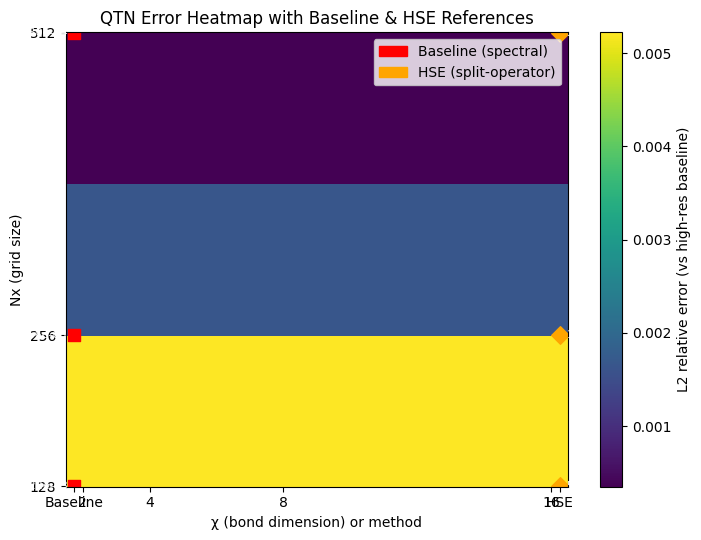

In [6]:
# %% [markdown]
# # Step 5 Add-on: Fancy Heatmap with Baseline/HSE Reference Overlays

# We assume `df`, `Nx_values`, `chi_values`, and `pivot_err` already exist from the previous Step 5 cell

import matplotlib.patches as mpatches

plt.figure(figsize=(7.2,5.5))
# Heatmap
im = plt.imshow(
    pivot_err.values,
    origin="lower",
    aspect="auto",
    cmap="viridis",
    extent=[min(chi_values)-0.5, max(chi_values)+0.5,
            min(Nx_values)-0.5, max(Nx_values)+0.5]
)
cbar = plt.colorbar(im)
cbar.set_label("L2 relative error (vs high-res baseline)")

# Overlay baseline & HSE error points at "infinite χ"
baseline_errors = df[df["method"]=="baseline"].set_index("Nx")["L2_rel_error"]
hse_errors      = df[df["method"]=="hse"].set_index("Nx")["L2_rel_error"]

for Nx in Nx_values:
    # plot baseline as left offset
    plt.scatter(min(chi_values)-0.25, Nx, color="red", s=80, marker="s", label="Baseline" if Nx==Nx_values[0] else "")
    plt.text(min(chi_values)-0.45, Nx, f"{baseline_errors[Nx]:.2e}", color="white", va="center", ha="right", fontsize=8)
    # plot hse as right offset
    plt.scatter(max(chi_values)+0.25, Nx, color="orange", s=80, marker="D", label="HSE" if Nx==Nx_values[0] else "")
    plt.text(max(chi_values)+0.45, Nx, f"{hse_errors[Nx]:.2e}", color="white", va="center", ha="left", fontsize=8)

plt.xticks(chi_values + [min(chi_values)-0.25, max(chi_values)+0.25],
           [str(c) for c in chi_values] + ["Baseline", "HSE"])
plt.yticks(Nx_values)
plt.xlabel("χ (bond dimension) or method")
plt.ylabel("Nx (grid size)")
plt.title("QTN Error Heatmap with Baseline & HSE References")

# Legend
handles = [
    mpatches.Patch(color="red", label="Baseline (spectral)"),
    mpatches.Patch(color="orange", label="HSE (split-operator)")
]
plt.legend(handles=handles, loc="upper right")

plt.tight_layout()
plt.savefig(os.path.join(outdir, "qtn_heatmap_with_refs.png"), dpi=150)
plt.show()
